# CC Scheme

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import os
import xcorr

In [2]:
%matplotlib notebook

In [3]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [4]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_lag = (0., 9*3600.) # s
poi = {'name': 'MVC', 'latitude': -25.887, 'longitude': -177.188, 'elevation': 0., 'local_depth': 132.}

attrs = {
    'title': 'Monowai Volcanic Centre',
    'institution': 'Delft University of Technology, Department of Geoscience and Engineering',
    'author': 'Pieter Smets - P.S.M.Smets@tudelft.nl',
    'source': 'CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data',
}

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        # ('remove_sensitivity', {}),
        ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
}

<IPython.core.display.Javascript object>


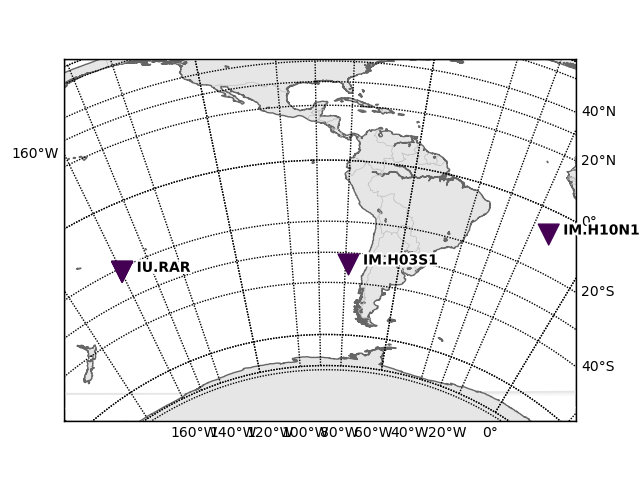

In [5]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
    'IM.H03S1..EDH-IU.RAR.10.BHZ',
    'IM.H03S1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2015-01-15', '2015-01-18', freq='1D')

inv = xcorr.util.get_pair_inventory(pairs, read_inventory('../data/Monowai.xml'), times)

fig = inv.plot(color=0., projection='local')

## Correlate one day of data

In [6]:
pair = pairs[0]
time = times[0]

ds = xcorr.init(
    pair=pair,
    starttime=time,
    endtime=time + pd.offsets.DateOffset(1), 
    attrs=attrs,
    preprocess=preprocess, 
    sampling_rate=sampling_rate, 
    window_length=window_length, 
    window_overlap=window_overlap, 
    clip_lag=clip_lag,
    unbiased_cc=False,
    inventory=inv,
    stationary_poi=poi,
)

pair 2b3cbcdaeabd93f93b6af85f889e80fb2ea4ef8a1df9dbcde7597139edcba792
time a527ec3538c71e943341c75c43d8510e0f8621b2608eab0b016e5f2869281de9
lag b6d4eed8509b79936bf5b05ba4f1f49c55d4dfac09f6dbac2f30e54226c66a9e
distance 3d7beb17fa3234da807df5757df2b08936f7350c0ce39360fe0c1bff756cb3fe
status 663b297826d217cd47b7ad24071202d1e2b726d71eed7a242e8e107fe05a060d
pair_offset aad948fcaeae46ba8543395d901136c87435f6e99e9a24a9b389f9041078c10e
time_offset dee09998dc5e41956ea57cbd4e84433c873fd7da4160272254083b1679b518ea
cc 0186a549c7f391d686d17287c5bcf7dc8343f5e9f392da3d2c82f644985bdbc7
Dataset hash 0186a549c7f391d686d17287c5bcf7dc8343f5e9f392da3d2c82f644985bdbc7


In [ ]:
xcorr.process(ds, inventory=inv, client=client, test_run=True)

In [ ]:
plt.figure(figsize=[9,4])
ds.cc.loc[{'time': ds.time[0]}].plot.line(x='lag')

In [ ]:
xcorr.write(ds, 'test.nc', verb=1)

In [16]:
ds1 = xcorr.read('test.nc', verb=1)

test.nc #(status==1): 1 of 8


### A whole period

In [ ]:
root = '../data/results'
warnings.filterwarnings('ignore')  # no warnings of duplicate inventory items

for pair in pairs:
    print('---------------------------')
    print(pair)
    print('---------------------------')
    for time in times:
        ncfile = xcorr.util.ncfile(pair, time, root)
        ds = False
        if os.path.isfile(ncfile):
            ds = xr.open_dataset(ncfile)
            if ds and np.all(ds.status.values == 1):
                ds.close()
                continue
        if not ds:
            ds = xcorr.init_dataset(
                pair=pair,
                starttime=time,
                endtime=time + pd.offsets.DateOffset(1), 
                attrs=attrs,
                preprocess=preprocess, 
                sampling_rate=sampling_rate, 
                window_length=window_length, 
                window_overlap=window_overlap, 
                clip_lag=clip_lag,
                unbiased_cc=False,
                inventory=inv,
                stationary_poi=poi,
            )
        try:
            xcorr.cc_dataset(
                ds,
                inventory=inv.select(
                    starttime=UTCDateTime(time),
                    endtime=UTCDateTime(time + pd.offsets.DateOffset(1))
                ),
                client=client,
                retry_missing=True,
            )
        except (KeyboardInterrupt, SystemExit):
            raise
        except Exception as e:
            print('An error occurred. Save and continue next timestep or pair.')
            print('Error:')
            print(e)
        if ds and np.any(ds.status.values != 0):
            xcorr.write_dataset(ds,ncfile)